### Testing with the 2.8K synthetic data set

In [1]:
import os
import cv2
import tempfile 
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.mixed_precision import set_global_policy
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
from google.cloud import storage

2023-11-19 23:34:02.291952: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-19 23:34:02.292012: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-19 23:34:02.292046: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-19 23:34:02.301597: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set the global policy to mixed_float16
set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


2023-11-19 23:34:04.724447: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-19 23:34:04.735371: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-19 23:34:04.738341: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
# Ensure the script uses the GPU if available and set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set at program startup
        print(e)

#### Initialize storage bucket

In [6]:
# Initialize the Google Cloud Storage client
storage_client = storage.Client()

# Replace 'your-bucket-name' with the actual name of your Google Cloud Storage bucket
bucket_name = 'asl_test_images'
bucket = storage_client.get_bucket(bucket_name)

## YOLOV5

In [7]:
# import sys
# sys.path.append('yolov5')  # Add the YOLOv5 directory to the Python path

# import torch
# from pathlib import Path
# from models.experimental import attempt_load
# from PIL import Image
# from torchvision import transforms

In [5]:
# # Load the YOLOv5 model on GPUs if available, otherwise on CPU
# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# # Specify the path to the YOLOv5 model weights file
# model_weights_path = 'yolov5/runs/train/exp20/weights/best.pt'

# # Load the YOLOv5 model
# model = torch.load(model_weights_path, map_location=device)['model'].float()
# model.eval()

In [26]:
# # Label mapping (modify as needed)
# label_mapping = {0: 'A', 1: 'B', 2: 'C'}  # Replace with your class labels

# # Predict and collect actuals and predictions
# actuals = []
# predictions = []

# # Get a list of all blobs in the bucket to calculate total images for progress indication
# all_blobs = list(bucket.list_blobs())
# total_images = sum(1 for blob in all_blobs if blob.name.lower().endswith('.png'))
# processed_images_count = 0

# # Start time
# start_time = time.time()

# # Iterate over the blobs in the bucket
# for blob in all_blobs:
#     if blob.name.lower().endswith('.png'):
#         # Download the image to a temporary file
#         _, temp_local_filename = tempfile.mkstemp(suffix='.png')
#         blob.download_to_filename(temp_local_filename)
        
#         # Load and preprocess the image for inference
#         image = Image.open(temp_local_filename)
#         image = image.convert('RGB')
#         transform = transforms.ToTensor()
#         image = transform(image).unsqueeze(0).to(device)

#         # Perform inference on the image
#         with torch.no_grad():
#             results = model(image)  # This will contain the detected objects
        
#         # Extract the first element (detections) from the tuple
#         detections = results[0]

#         # Iterate through each detected object
#         for det in detections[0]:
#             class_idx = int(det[5].item())  # Extract the class index correctly
#             confidence = float(det[4].item())  # Extract the confidence score correctly
#             class_label = label_mapping.get(class_idx, 'unknown')  # Assign 'unknown' for unrecognized classes
            
#             # Store the true label and predicted label (modify as needed)
#             actuals.append(blob.name.split('/')[0])
#             predictions.append(class_label)

#         # Delete the temporary file
#         os.remove(temp_local_filename)
        
#         # Increment the count and print the progress
#         processed_images_count += 1
#         progress_percentage = (processed_images_count / total_images) * 100
#         print(f"Progress: {progress_percentage:.2f}%", end="\r")

# # End time
# end_time = time.time()

# # Calculate and print the total duration
# total_duration = end_time - start_time
# print(f"\nTotal time taken for predictions: {total_duration:.2f} seconds")


KeyboardInterrupt: 

In [39]:
# def resize_and_pad(image, desired_size=640):
#     old_size = image.size  # old_size[0] is in (width, height) format
#     ratio = float(desired_size) / max(old_size)
#     new_size = tuple([int(x * ratio) for x in old_size])
    
#     # Resize the image with the new size and use the LANCZOS resampling filter
#     image = image.resize(new_size, Image.Resampling.LANCZOS)

#     # Create a new image and paste the resized image onto it
#     new_image = Image.new("RGB", (desired_size, desired_size))
#     new_image.paste(image, ((desired_size - new_size[0]) // 2,
#                             (desired_size - new_size[1]) // 2))

#     return new_image

In [1]:
# # # Define folder-to-class mapping
# folder_to_class = {'0': 'A', '1': 'B', '2': 'C'}

# # # Label mapping (modify as needed)
# label_mapping = {0: 'A', 1: 'B', 2: 'C'}

# # Predict and collect actuals and predictions
# actuals = []
# predictions = []

# # Track the last processed folder
# last_processed_folder = -1

# # Start time
# start_time = time.time()

# # Get a list of all blobs in the bucket to calculate total images for progress indication
# all_blobs = list(bucket.list_blobs())

# # # Iterate over the blobs in the bucket
# for blob in all_blobs:
#     if blob.name.lower().endswith('.png'):
#         # Extract the folder name from the blob's path
#         folder_name = blob.name.split('/')[0]
        
#         # Convert the folder number to an integer and check if it's in range 0-2
#         folder_number = int(folder_name) if folder_name.isdigit() else -1
#         # print('folder number: ', folder_number)
#         if 0 <= folder_number <= 2:
#             # Process the image only if it's in one of the target folders
#             # Download the image to a temporary file
#             _, temp_local_filename = tempfile.mkstemp(suffix='.png')
#             blob.download_to_filename(temp_local_filename)
            
#             # Load and preprocess the image for inference
#             image = Image.open(temp_local_filename)
#             image = image.convert('RGB')

#             # Resize and pad the image to the desired size (640x640 in this case)
#             image = resize_and_pad(image, desired_size=640)

#             # Convert the image to a tensor
#             transform = transforms.ToTensor()
#             image = transform(image).unsqueeze(0).to(device)

#             # Perform inference on the image
#             with torch.no_grad():
#                 results = model(image)  # This will contain the detected objects

#             # Extract the first element (detections) from the tuple
#             detections = results[0]

#             # Iterate through each detected object
#             for det in detections[0]:
#                 class_idx = int(det[5].item())  # Extract the class index correctly
#                 confidence = float(det[4].item())  # Extract the confidence score correctly
#                 if folder_number == 2:
#                     print('folder number: ', folder_number)
#                     # Debug print statements
#                     print(f"Class Index: {class_idx}, Confidence: {confidence}")
#                     print(f"Label mapping for class_idx: {label_mapping.get(class_idx)}")
                
#                 # Map class index to class label
#                 class_label = label_mapping.get(class_idx)
                
#                 # Store the true label and predicted label
#                 actual_label = folder_to_class.get(folder_name)
#                 if folder_number == 2:
#                     print(f"Actual label for folder {folder_name}: {actual_label}")

#                 # Store the true label and predicted label (modify as needed)
#                 actuals.append(folder_to_class[folder_name])  # Use folder-to-class mapping
#                 predictions.append(class_label)
            
#             # Delete the temporary file
#             os.remove(temp_local_filename)
            
#             # Update progress if a new folder is started
#             if folder_number != last_processed_folder:
#                 last_processed_folder = folder_number
#                 progress = (folder_number + 1) / 3  # Progress based on folder completion
#                 print(f"Progress: {progress:.2f} (Folder {folder_number + 1}/3)", end="\r")

# # # End time
# end_time = time.time()

#  # Calculate and print the total duration
# total_duration = end_time - start_time#
# print(f"\nTotal time taken for predictions: {total_duration:.2f} seconds")


In [14]:
# # Define the subset of labels you want to include in the confusion matrix
# subset_labels = ['A', 'B', 'C']

# # Create a mask to filter actuals and predictions for the subset of labels
# mask = [label in subset_labels for label in actuals]

# # Filter actuals and predictions based on the mask
# subset_actuals = [actual for actual, include in zip(actuals, mask) if include]
# subset_predictions = [prediction for prediction, include in zip(predictions, mask) if include]

# # Create confusion matrix using subset_actuals and subset_predictions
# conf_matrix = confusion_matrix(subset_actuals, subset_predictions, labels=subset_labels)
# print("Confusion Matrix:\n", conf_matrix)


# # Calculate overall accuracy
# total_samples = np.sum(conf_matrix)
# if total_samples == 0:
#     overall_accuracy = 0.0
# else:
#     overall_accuracy = np.trace(conf_matrix) / total_samples * 100

# print('OVERALL ACCURACY: ', overall_accuracy)

# # Create a heatmap using Seaborn
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="Blues", xticklabels=subset_labels, yticklabels=subset_labels)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()


In [15]:
# # Initialize the LabelBinarizer
# label_binarizer = LabelBinarizer()

# # Fit the label binarizer on all possible labels
# label_binarizer.fit(['A', 'B', 'C'])

# # Transform actuals and predictions to one-hot format
# onehot_actuals = label_binarizer.transform(subset_actuals)
# onehot_predictions = label_binarizer.transform(subset_predictions)

# average_precisions = {}
# labels = ['A', 'B', 'C']

# # Iterate through classes
# for i, label in enumerate(labels):
#     # Calculate average precision
#     ap_score = average_precision_score(onehot_actuals[:, i], onehot_predictions[:, i])
#     average_precisions[label] = ap_score

# # Calculate the mean average precision
# mean_ap_value = np.mean(list(average_precisions.values()))

# # Sort the average_precisions dictionary by values in descending order
# sorted_average_precisions = {k: v for k, v in sorted(average_precisions.items(), key=lambda item: item[1], reverse=True)}

# # Create the bar chart with sorted values
# plt.figure(figsize=(12, 9))
# sorted_classes = list(sorted_average_precisions.keys())
# sorted_aps = list(sorted_average_precisions.values())

# plt.barh(sorted_classes, sorted_aps, color='blue')
# plt.xlabel('Average Precision')
# plt.title(f'mAP = {mean_ap_value:.2%}')
# plt.gca().invert_yaxis()  # Invert the y-axis to have the highest AP on top

# # Annotate each bar with the AP value
# for i, v in enumerate(sorted_aps):
#     plt.text(v + 0.01, i, f"{v:.2f}", color='black', va='center')

# plt.show()

# # Output overall accuracy and mAP
# print(f'mAP: {mean_ap_value:.2%}')

In [16]:
# # Create an empty dictionary to store average precisions
# average_precisions = {}

# # Iterate through classes
# for i, label in enumerate(label_encoder.classes_):
#     # Check if there are any samples for this class before calculating average precision
#     if np.sum(onehot_actuals[:, i]) > 0:
#         ap_score = average_precision_score(onehot_actuals[:, i], onehot_predictions[:, i])
#         average_precisions[label] = ap_score

# # Calculate the mean average precision
# mean_ap_value = np.mean(list(average_precisions.values()))

# # Sort the average_precisions dictionary by values in descending order
# sorted_average_precisions = {k: v for k, v in sorted(average_precisions.items(), key=lambda item: item[1], reverse=True)}

# # Create the bar chart with sorted values
# plt.figure(figsize=(12, 9))
# sorted_classes = list(sorted_average_precisions.keys())
# sorted_aps = list(sorted_average_precisions.values())

# plt.barh(sorted_classes, sorted_aps, color='blue')
# plt.xlabel('Average Precision')
# plt.title(f'mAP = {mean_ap_value:.2%}')
# plt.gca().invert_yaxis()  # Invert the y-axis to have the highest AP on top

# # Annotate each bar with the AP value
# for i, v in enumerate(sorted_aps):
#     plt.text(v + 0.01, i, f"{v:.2f}", color='black', va='center')

# plt.show()

# # Output overall accuracy and mAP
# print(f'Overall Accuracy: {overall_accuracy:.2f}%')
# print(f'mAP: {mean_ap_value:.2%}')


## MobileNet

In [17]:
# Preprocessing function adjusted for single images
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = img.astype('float32') / 255.0
    return img

In [18]:
# Load your model
mobilenet = load_model('mobilenet-model.h5')

# Label mapping
label_mapping = {str(i): chr(65 + i) for i in range(26)}

# Predict and collect actuals and predictions
actuals = []
predictions = []

# Get a list of all blobs in the bucket to calculate total images for progress indication
all_blobs = list(bucket.list_blobs())
total_images = sum(1 for blob in all_blobs if blob.name.lower().endswith('.png'))
processed_images_count = 0

# Start time
start_time = time.time()

# Iterate over the blobs in the bucket
for blob in all_blobs:
    if blob.name.lower().endswith('.png'):
        # Extract the label from the folder number
        folder_name = os.path.basename(os.path.dirname(blob.name))
        if folder_name.isdigit():
            label = label_mapping[folder_name]
            # Download the image to a temporary file
            _, temp_local_filename = tempfile.mkstemp(suffix='.png')
            blob.download_to_filename(temp_local_filename)
            
            # Preprocess the image and predict
            processed_image = preprocess_image(temp_local_filename)
            processed_image = np.expand_dims(processed_image, axis=0)  # Add batch dimension
            prediction = mobilenet.predict(processed_image, verbose=0)
            predicted_label = np.argmax(prediction, axis=1)[0]
            
            # Convert predicted label index back to a character
            predicted_label_char = label_mapping[str(predicted_label)]
            
            # Store the true label and predicted label
            actuals.append(label)
            predictions.append(predicted_label_char)
            
            # Delete the temporary file
            os.remove(temp_local_filename)
            
            # Increment the count and print the progress
            processed_images_count += 1
            progress_percentage = (processed_images_count / total_images) * 100
            print(f"Progress: {progress_percentage:.2f}%", end="\r")
            
# End time
end_time = time.time()

# Calculate and print the total duration
total_duration = end_time - start_time
print(f"\nTotal time taken for predictions: {total_duration:.2f} seconds")

2023-11-19 23:04:41.809063: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8900


Progress: 100.00%
Total time taken for predictions: 403.27 seconds


#### Visualizing outcome

OVERALL ACCURACY:  37.41346153846154


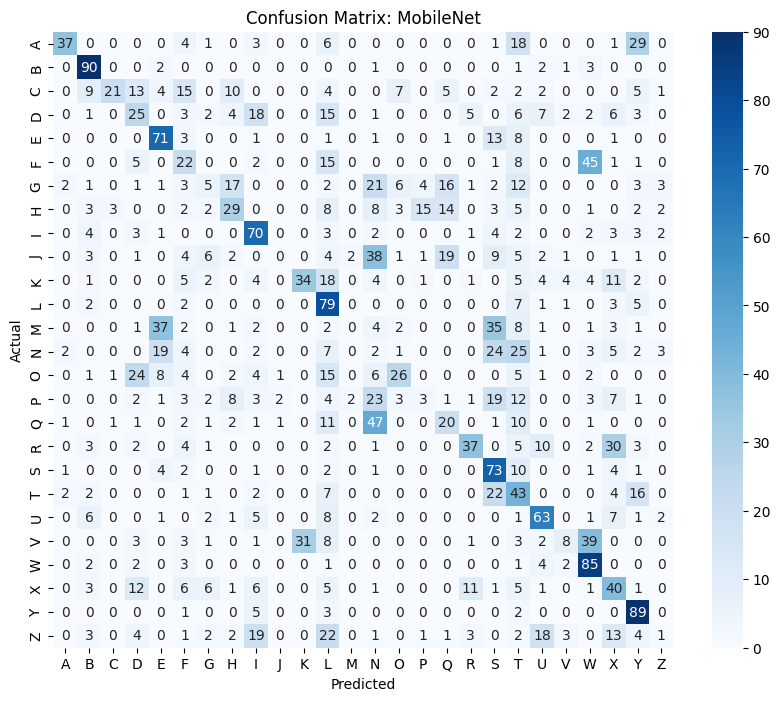

In [19]:
color_palette = "Blues"

labels_dict = {0: 'A', 1: 'B', 2: 'C',
               3: 'D', 4: 'E', 5: 'F',
               6: 'G', 7: 'H', 8: 'I',
               9: 'J', 10: 'K', 11: 'L',
               12: 'M', 13: 'N', 14: 'O', 
               15: 'P', 16: 'Q', 17: 'R', 
               18: 'S', 19: 'T', 20: 'U', 
               21: 'V', 22: 'W', 23: 'X', 
               24: 'Y', 25: 'Z'}
             
# Create confusion matrix
conf_matrix = confusion_matrix(actuals, predictions)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Convert the confusion matrix to string format
conf_matrix_str = np.array2string(conf_matrix)

file_path = "mobilenet_conf_matrix.txt"

# Save the string representation of the confusion matrix to a text file
with open(file_path, "w") as file:
    file.write(conf_matrix_str)

# Calculate overall accuracy
overall_accuracy = np.trace(conf_matrix) / np.sum(conf_matrix) * 100
print('OVERALL ACCURACY: ', overall_accuracy)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
labels = list(labels_dict.values())
sns.heatmap(conf_matrix, annot=True, fmt=".0f", 
            cmap = color_palette, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: MobileNet')
plt.show()

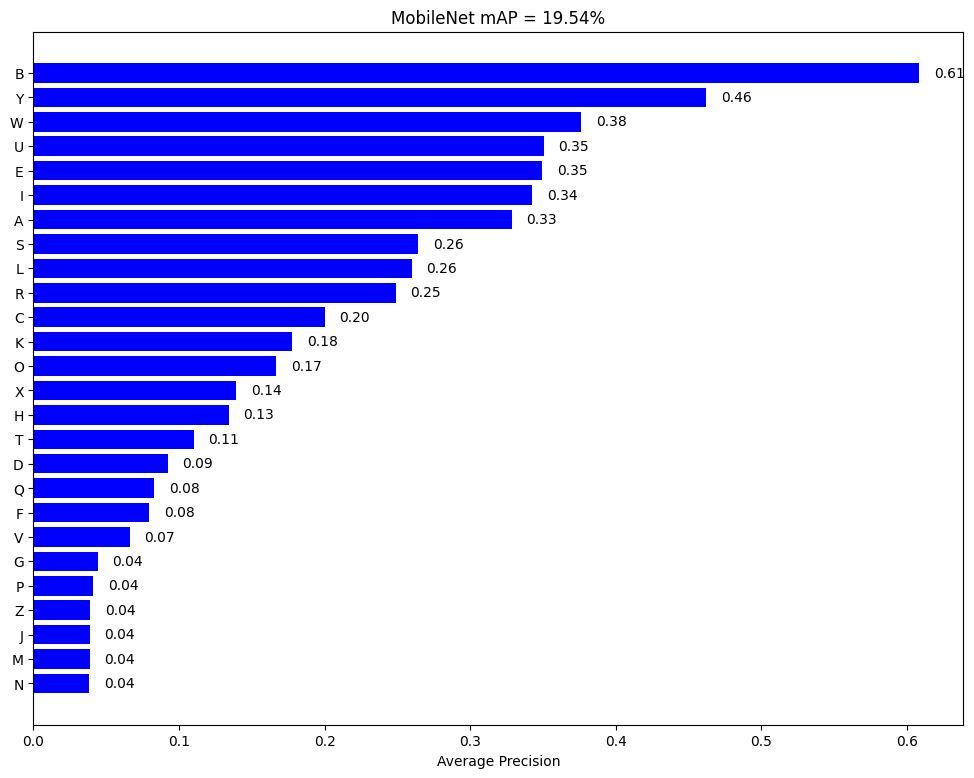

In [20]:
# Convert the actuals and predictions to numerical form
label_encoder = LabelEncoder()
encoded_actuals = label_encoder.fit_transform(actuals)
encoded_predictions = label_encoder.transform(predictions)

# One-hot encode the labels
num_classes = len(label_mapping)
onehot_actuals = np.eye(num_classes)[encoded_actuals]
onehot_predictions = np.eye(num_classes)[encoded_predictions]

# Calculate the AP for each class
average_precisions = {label: average_precision_score(onehot_actuals[:, i], onehot_predictions[:, i])
                      for i, label in enumerate(label_encoder.classes_)}

# Calculate the mean average precision
mean_ap_value = np.mean(list(average_precisions.values()))

# Sort the average_precisions dictionary by values in descending order
sorted_average_precisions = {k: v for k, v in sorted(average_precisions.items(), key=lambda item: item[1], reverse=True)}

# Create the bar chart with sorted values
plt.figure(figsize=(12, 9))
sorted_classes = list(sorted_average_precisions.keys())
sorted_aps = list(sorted_average_precisions.values())

plt.barh(sorted_classes, sorted_aps, color='blue')
plt.xlabel('Average Precision')
plt.title(f'MobileNet mAP = {mean_ap_value:.2%}')
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest AP on top

# Annotate each bar with the AP value
for i, v in enumerate(sorted_aps):
    plt.text(v + 0.01, i, f"{v:.2f}", color='black', va='center')

plt.show()


## GoogleNet

In [7]:
def preprocess_image(img_path):
    image_size=(299, 299)
    img = cv2.imread(img_path)
    img = cv2.resize(img, image_size)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)  # Correctly adding a batch dimension
    return img

### Deep architecture

In [9]:
# Load your model
googlenet = load_model('googlenet-model.h5')

# Label mapping
label_mapping = {str(i): chr(65 + i) for i in range(26)}

# Predict and collect actuals and predictions
actuals = []
predictions = []

# Get a list of all blobs in the bucket to calculate total images for progress indication
all_blobs = list(bucket.list_blobs())
total_images = sum(1 for blob in all_blobs if blob.name.lower().endswith('.png'))
processed_images_count = 0

# Start time
start_time = time.time()

# Iterate over the blobs in the bucket
for blob in all_blobs:
    if blob.name.lower().endswith('.png'):
        # Extract the label from the folder number
        folder_name = os.path.basename(os.path.dirname(blob.name))
        if folder_name.isdigit():
            label = label_mapping[folder_name]
            # Download the image to a temporary file
            _, temp_local_filename = tempfile.mkstemp(suffix='.png')
            blob.download_to_filename(temp_local_filename)
            
            # Preprocess the image and predict
            processed_image = preprocess_image(temp_local_filename)
            prediction = googlenet.predict(processed_image, verbose=0)
            predicted_label = np.argmax(prediction, axis=1)[0]
            
            # Convert predicted label index back to a character
            predicted_label_char = label_mapping[str(predicted_label)]
            
            # Store the true label and predicted label
            actuals.append(label)
            predictions.append(predicted_label_char)
            
            # Delete the temporary file
            os.remove(temp_local_filename)
            
            # Increment the count and print the progress
            processed_images_count += 1
            progress_percentage = (processed_images_count / total_images) * 100
            print(f"Progress: {progress_percentage:.2f}%", end="\r")
            
# End time
end_time = time.time()

# Calculate and print the total duration
total_duration = end_time - start_time
print(f"\nTotal time taken for predictions: {total_duration:.2f} seconds")

2023-11-16 02:52:32.272665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 02:52:32.274662: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 02:52:32.276639: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-11-16 02:52:39.581579: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8900


Progress: 100.00%
Total time taken for predictions: 357.93 seconds


OVERALL ACCURACY:  33.81730769230769


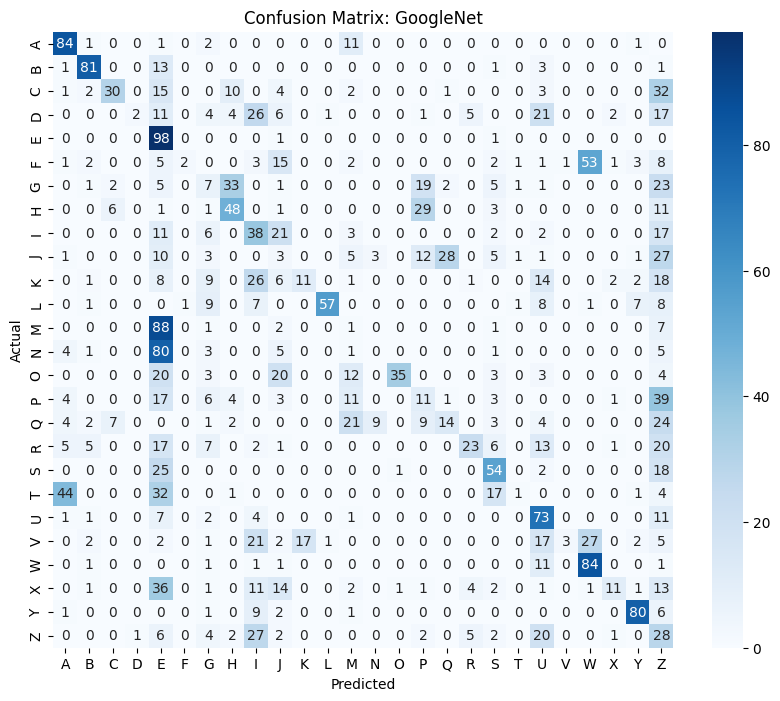

In [10]:
color_palette = "Blues"

labels_dict = {0: 'A', 1: 'B', 2: 'C',
               3: 'D', 4: 'E', 5: 'F',
               6: 'G', 7: 'H', 8: 'I',
               9: 'J', 10: 'K', 11: 'L',
               12: 'M', 13: 'N', 14: 'O', 
               15: 'P', 16: 'Q', 17: 'R', 
               18: 'S', 19: 'T', 20: 'U', 
               21: 'V', 22: 'W', 23: 'X', 
               24: 'Y', 25: 'Z'}
             
# Create confusion matrix
conf_matrix = confusion_matrix(actuals, predictions)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Convert the confusion matrix to string format
conf_matrix_str = np.array2string(conf_matrix)

file_path = "googlenet_deep_conf_matrix.txt"

# Save the string representation of the confusion matrix to a text file
with open(file_path, "w") as file:
    file.write(conf_matrix_str)

# Calculate overall accuracy
overall_accuracy = np.trace(conf_matrix) / np.sum(conf_matrix) * 100
print('OVERALL ACCURACY: ', overall_accuracy)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
labels = list(labels_dict.values())
sns.heatmap(conf_matrix, annot=True, fmt=".0f", 
            cmap = color_palette, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: GoogleNet')
plt.show()

### Shallow architecture

In [12]:
# Load your model
googlenet_shallow = load_model('1c-googlenet-model.h5')

# Print the number of layers
print("Number of layers in the model:", len(googlenet_shallow.layers))

Number of layers in the model: 315


In [8]:
# Load your model
googlenet = load_model('1c-googlenet-model.h5')

# Label mapping
label_mapping = {str(i): chr(65 + i) for i in range(26)}

# Predict and collect actuals and predictions
actuals = []
predictions = []

# Get a list of all blobs in the bucket to calculate total images for progress indication
all_blobs = list(bucket.list_blobs())
total_images = sum(1 for blob in all_blobs if blob.name.lower().endswith('.png'))
processed_images_count = 0

# Start time
start_time = time.time()

# Iterate over the blobs in the bucket
for blob in all_blobs:
    if blob.name.lower().endswith('.png'):
        # Extract the label from the folder number
        folder_name = os.path.basename(os.path.dirname(blob.name))
        if folder_name.isdigit():
            label = label_mapping[folder_name]
            # Download the image to a temporary file
            _, temp_local_filename = tempfile.mkstemp(suffix='.png')
            blob.download_to_filename(temp_local_filename)
            
            # Preprocess the image and predict
            processed_image = preprocess_image(temp_local_filename)
            prediction = googlenet.predict(processed_image, verbose=0)
            predicted_label = np.argmax(prediction, axis=1)[0]
            
            # Convert predicted label index back to a character
            predicted_label_char = label_mapping[str(predicted_label)]
            
            # Store the true label and predicted label
            actuals.append(label)
            predictions.append(predicted_label_char)
            
            # Delete the temporary file
            os.remove(temp_local_filename)
            
            # Increment the count and print the progress
            processed_images_count += 1
            progress_percentage = (processed_images_count / total_images) * 100
            print(f"Progress: {progress_percentage:.2f}%", end="\r")
            
# End time
end_time = time.time()

# Calculate and print the total duration
total_duration = end_time - start_time
print(f"\nTotal time taken for predictions: {total_duration:.2f} seconds")

2023-11-17 23:41:49.233611: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-17 23:41:49.235701: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-17 23:41:49.237630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-11-17 23:42:13.766442: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8900


Progress: 100.00%
Total time taken for predictions: 476.59 seconds


OVERALL ACCURACY:  41.30769230769231


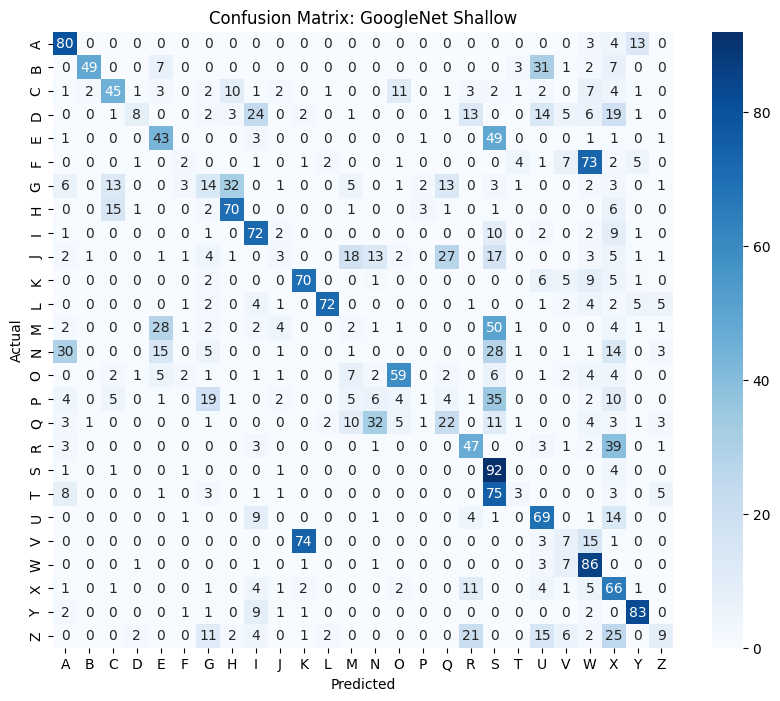

In [16]:
color_palette = "Blues"

labels_dict = {0: 'A', 1: 'B', 2: 'C',
               3: 'D', 4: 'E', 5: 'F',
               6: 'G', 7: 'H', 8: 'I',
               9: 'J', 10: 'K', 11: 'L',
               12: 'M', 13: 'N', 14: 'O', 
               15: 'P', 16: 'Q', 17: 'R', 
               18: 'S', 19: 'T', 20: 'U', 
               21: 'V', 22: 'W', 23: 'X', 
               24: 'Y', 25: 'Z'}
             
# Create confusion matrix
conf_matrix = confusion_matrix(actuals, predictions)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Convert the confusion matrix to string format
conf_matrix_str = np.array2string(conf_matrix)

file_path = "googlenet_shallow_conf_matrix.txt"

# Save the string representation of the confusion matrix to a text file
with open(file_path, "w") as file:
    file.write(conf_matrix_str)

# Calculate overall accuracy
overall_accuracy = np.trace(conf_matrix) / np.sum(conf_matrix) * 100
print('OVERALL ACCURACY: ', overall_accuracy)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
labels = list(labels_dict.values())
sns.heatmap(conf_matrix, annot=True, fmt=".0f", 
            cmap = color_palette, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: GoogleNet Shallow')
plt.show()

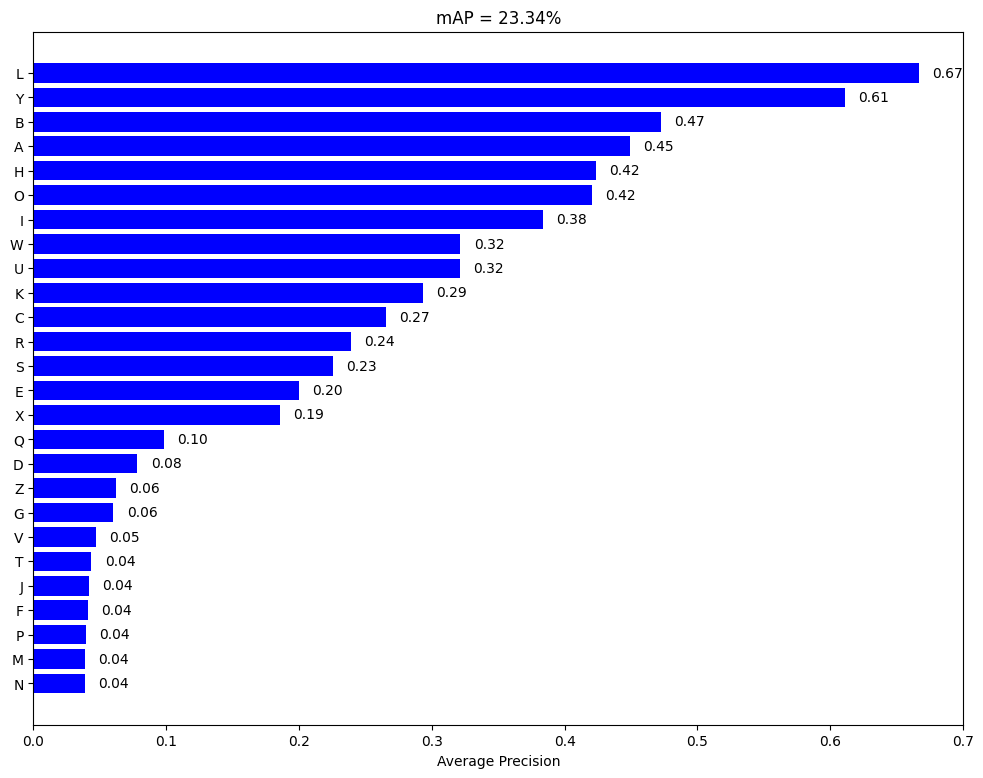

In [15]:
# Convert the actuals and predictions to numerical form
label_encoder = LabelEncoder()
encoded_actuals = label_encoder.fit_transform(actuals)
encoded_predictions = label_encoder.transform(predictions)

# One-hot encode the labels
num_classes = len(label_mapping)
onehot_actuals = np.eye(num_classes)[encoded_actuals]
onehot_predictions = np.eye(num_classes)[encoded_predictions]

# Calculate the AP for each class
average_precisions = {label: average_precision_score(onehot_actuals[:, i], onehot_predictions[:, i])
                      for i, label in enumerate(label_encoder.classes_)}

# Calculate the mean average precision
mean_ap_value = np.mean(list(average_precisions.values()))

# Sort the average_precisions dictionary by values in descending order
sorted_average_precisions = {k: v for k, v in sorted(average_precisions.items(), key=lambda item: item[1], reverse=True)}

# Create the bar chart with sorted values
plt.figure(figsize=(12, 9))
sorted_classes = list(sorted_average_precisions.keys())
sorted_aps = list(sorted_average_precisions.values())

plt.barh(sorted_classes, sorted_aps, color='blue')
plt.xlabel('Average Precision')
plt.title(f'GoogleNet mAP = {mean_ap_value:.2%}')
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest AP on top

# Annotate each bar with the AP value
for i, v in enumerate(sorted_aps):
    plt.text(v + 0.01, i, f"{v:.2f}", color='black', va='center')

plt.show()


## EfficientNet

In [4]:
def preprocess_image(img_path):
    image_size=(299, 299)
    img = cv2.imread(img_path)
    img = cv2.resize(img, image_size)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)  # Correctly adding a batch dimension
    return img

In [7]:
# Load your model
model = load_model('efficientnet-model.h5')

# Label mapping
label_mapping = {str(i): chr(65 + i) for i in range(26)}

# Predict and collect actuals and predictions
actuals = []
predictions = []

# Get a list of all blobs in the bucket to calculate total images for progress indication
all_blobs = list(bucket.list_blobs())
total_images = sum(1 for blob in all_blobs if blob.name.lower().endswith('.png'))
processed_images_count = 0

# Start time
start_time = time.time()

# Iterate over the blobs in the bucket
for blob in all_blobs:
    if blob.name.lower().endswith('.png'):
        # Extract the label from the folder number
        folder_name = os.path.basename(os.path.dirname(blob.name))
        if folder_name.isdigit():
            label = label_mapping[folder_name]
            # Download the image to a temporary file
            _, temp_local_filename = tempfile.mkstemp(suffix='.png')
            blob.download_to_filename(temp_local_filename)
            
            # Preprocess the image and predict
            processed_image = preprocess_image(temp_local_filename)
            prediction = model.predict(processed_image, verbose=0)
            predicted_label = np.argmax(prediction, axis=1)[0]
            
            # Convert predicted label index back to a character
            predicted_label_char = label_mapping[str(predicted_label)]
            
            # Store the true label and predicted label
            actuals.append(label)
            predictions.append(predicted_label_char)
            
            # Delete the temporary file
            os.remove(temp_local_filename)
            
            # Increment the count and print the progress
            processed_images_count += 1
            progress_percentage = (processed_images_count / total_images) * 100
            print(f"Progress: {progress_percentage:.2f}%", end="\r")
            
# End time
end_time = time.time()

# Calculate and print the total duration
total_duration = end_time - start_time
print(f"\nTotal time taken for predictions: {total_duration:.2f} seconds")

2023-11-19 23:34:35.973040: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8900


Progress: 100.00%
Total time taken for predictions: 305.86 seconds


OVERALL ACCURACY:  23.682692307692307


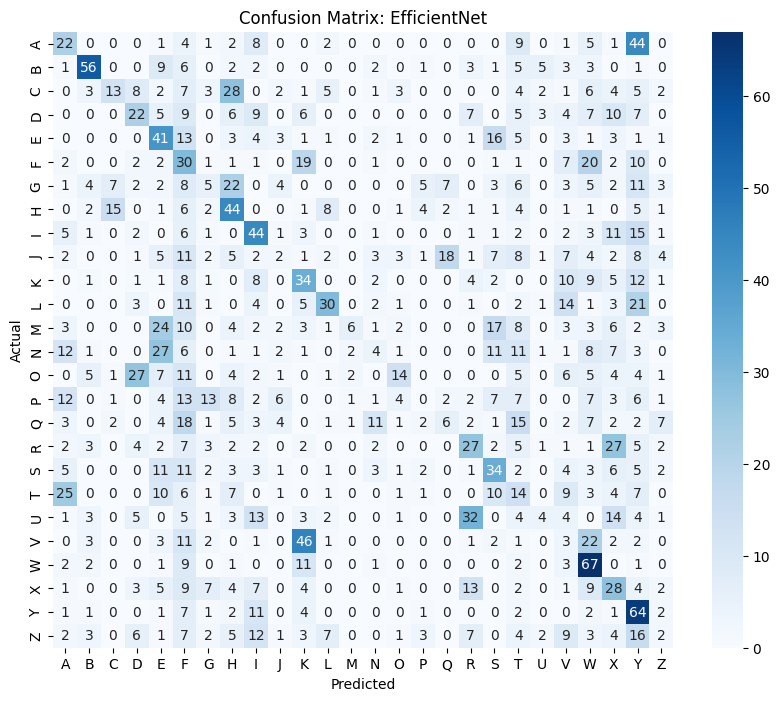

In [7]:
color_palette = "Blues"

labels_dict = {0: 'A', 1: 'B', 2: 'C',
               3: 'D', 4: 'E', 5: 'F',
               6: 'G', 7: 'H', 8: 'I',
               9: 'J', 10: 'K', 11: 'L',
               12: 'M', 13: 'N', 14: 'O', 
               15: 'P', 16: 'Q', 17: 'R', 
               18: 'S', 19: 'T', 20: 'U', 
               21: 'V', 22: 'W', 23: 'X', 
               24: 'Y', 25: 'Z'}
             
# Create confusion matrix
conf_matrix = confusion_matrix(actuals, predictions)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Convert the confusion matrix to string format
conf_matrix_str = np.array2string(conf_matrix)

file_path = "efficientnet_conf_matrix.txt"

# Save the string representation of the confusion matrix to a text file
with open(file_path, "w") as file:
    file.write(conf_matrix_str)

# Calculate overall accuracy
overall_accuracy = np.trace(conf_matrix) / np.sum(conf_matrix) * 100
print('OVERALL ACCURACY: ', overall_accuracy)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
labels = list(labels_dict.values())
sns.heatmap(conf_matrix, annot=True, fmt=".0f", 
            cmap = color_palette, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: EfficientNet')
plt.show()

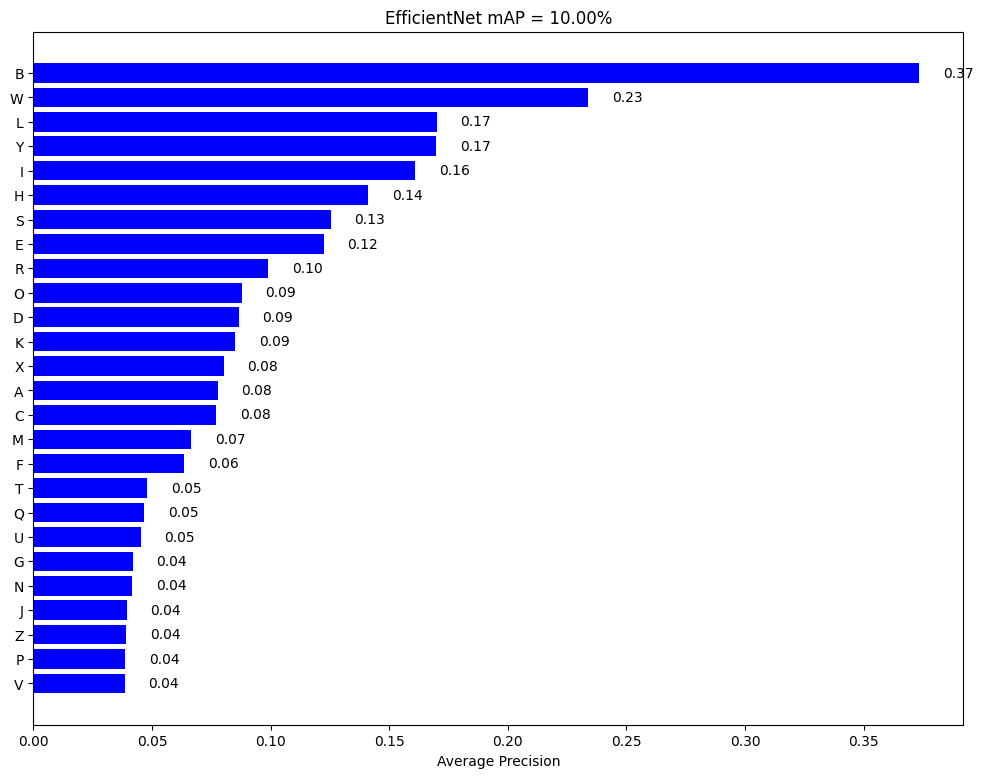

In [8]:
# Convert the actuals and predictions to numerical form
label_encoder = LabelEncoder()
encoded_actuals = label_encoder.fit_transform(actuals)
encoded_predictions = label_encoder.transform(predictions)

# One-hot encode the labels
num_classes = len(label_mapping)
onehot_actuals = np.eye(num_classes)[encoded_actuals]
onehot_predictions = np.eye(num_classes)[encoded_predictions]

# Calculate the AP for each class
average_precisions = {label: average_precision_score(onehot_actuals[:, i], onehot_predictions[:, i])
                      for i, label in enumerate(label_encoder.classes_)}

# Calculate the mean average precision
mean_ap_value = np.mean(list(average_precisions.values()))

# Sort the average_precisions dictionary by values in descending order
sorted_average_precisions = {k: v for k, v in sorted(average_precisions.items(), key=lambda item: item[1], reverse=True)}

# Create the bar chart with sorted values
plt.figure(figsize=(12, 9))
sorted_classes = list(sorted_average_precisions.keys())
sorted_aps = list(sorted_average_precisions.values())

plt.barh(sorted_classes, sorted_aps, color='blue')
plt.xlabel('Average Precision')
plt.title(f'EfficientNet mAP = {mean_ap_value:.2%}')
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest AP on top

# Annotate each bar with the AP value
for i, v in enumerate(sorted_aps):
    plt.text(v + 0.01, i, f"{v:.2f}", color='black', va='center')

plt.show()


## Custom

In [9]:
# Load your model
mobilenet = load_model('1b-custom-model.h5')

# Label mapping
label_mapping = {str(i): chr(65 + i) for i in range(26)}

# Predict and collect actuals and predictions
actuals = []
predictions = []

# Get a list of all blobs in the bucket to calculate total images for progress indication
all_blobs = list(bucket.list_blobs())
total_images = sum(1 for blob in all_blobs if blob.name.lower().endswith('.png'))
processed_images_count = 0

# Start time
start_time = time.time()

# Iterate over the blobs in the bucket
for blob in all_blobs:
    if blob.name.lower().endswith('.png'):
        # Extract the label from the folder number
        folder_name = os.path.basename(os.path.dirname(blob.name))
        if folder_name.isdigit():
            label = label_mapping[folder_name]
            # Download the image to a temporary file
            _, temp_local_filename = tempfile.mkstemp(suffix='.png')
            blob.download_to_filename(temp_local_filename)
            
            # Preprocess the image and predict
            processed_image = preprocess_image(temp_local_filename)
            processed_image = np.expand_dims(processed_image, axis=0)  # Add batch dimension
            prediction = mobilenet.predict(processed_image, verbose=0)
            predicted_label = np.argmax(prediction, axis=1)[0]
            
            # Convert predicted label index back to a character
            predicted_label_char = label_mapping[str(predicted_label)]
            
            # Store the true label and predicted label
            actuals.append(label)
            predictions.append(predicted_label_char)
            
            # Delete the temporary file
            os.remove(temp_local_filename)
            
            # Increment the count and print the progress
            processed_images_count += 1
            progress_percentage = (processed_images_count / total_images) * 100
            print(f"Progress: {progress_percentage:.2f}%", end="\r")
            
# End time
end_time = time.time()

# Calculate and print the total duration
total_duration = end_time - start_time
print(f"\nTotal time taken for predictions: {total_duration:.2f} seconds")

2023-11-14 19:32:12.675333: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 19:32:12.677383: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 19:32:12.679404: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-11-14 19:32:17.245323: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8900


Progress: 100.00%
Total time taken for predictions: 313.92 seconds


OVERALL ACCURACY:  4.125


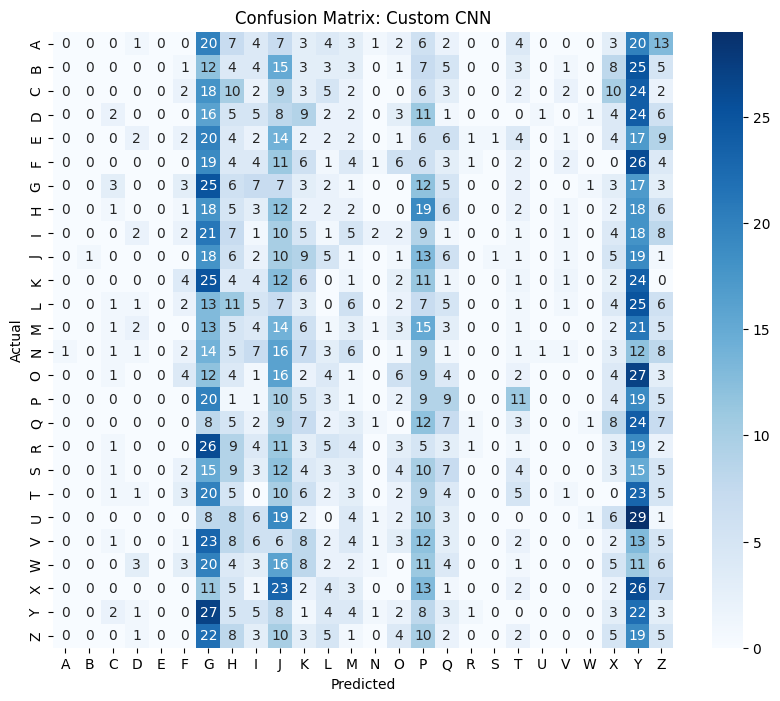

In [10]:
color_palette = "Blues"

labels_dict = {0: 'A', 1: 'B', 2: 'C',
               3: 'D', 4: 'E', 5: 'F',
               6: 'G', 7: 'H', 8: 'I',
               9: 'J', 10: 'K', 11: 'L',
               12: 'M', 13: 'N', 14: 'O', 
               15: 'P', 16: 'Q', 17: 'R', 
               18: 'S', 19: 'T', 20: 'U', 
               21: 'V', 22: 'W', 23: 'X', 
               24: 'Y', 25: 'Z'}
             
# Create confusion matrix
conf_matrix = confusion_matrix(actuals, predictions)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Calculate overall accuracy
overall_accuracy = np.trace(conf_matrix) / np.sum(conf_matrix) * 100
print('OVERALL ACCURACY: ', overall_accuracy)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
labels = list(labels_dict.values())
sns.heatmap(conf_matrix, annot=True, fmt=".0f", 
            cmap = color_palette, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Custom CNN')
plt.show()